In [1]:
from mkt.ml.models.factor_model import LogisticTensorFactorModel

In [2]:
from mkt.schema.io_utils import get_repo_root

In [22]:
import numpy as np

In [3]:
import pandas as pd

In [4]:
df_factor = pd.read_csv("/data1/tanseyw/projects/whitej/missense-kinase-toolkit/data/mskimpact_treatment_factor.csv")

In [55]:
df_factor.head()

,hgnc,klifs,drug,p(drug|mut)
0,EGFR,a.l:84,Leucovorin,0.003254
1,EGFR,a.l:84,Enfortumab Vedotin,0.000000
2,EGFR,a.l:84,Olaparib,0.000000
3,EGFR,a.l:84,Osimertinib,0.312907
4,EGFR,a.l:84,Vorasidenib,0.000000


In [56]:
df_shuffled.head()

,hgnc,klifs,drug,p(drug|mut)
0,SRC,g.l:7,Bendamustine,0.0
1,PLK2,I:2,Elacestrant,0.0
2,FLT1,b.l:35,Larotrectinib,0.0
3,MAP2K1,αD:54,Gefitinib,0.0
4,EGFR,VII:76,Cu64 Nota-Psmai-Peg-Cy55-C' Dots,0.0


In [123]:
arr = np.array_split(np.array(range(col_series.nunique())), 5)

[]

In [107]:
def generate_split_dataframe(
    df_in: pd.DataFrame, 
    seed: int = 42, 
    str_y: str = "p(drug|mut)",
) -> tuple[pd.DataFrame, dict]:
    """Shuffle dataframe, split on 

    Parameters
    ----------
    df_in: pd.DataFrame
        Dataframe to annotate with splits.
    seed: int
        Seed for shuffling; default: 42.

    Returns
    -------
    tuple[pd.DataFrame, dict]
        Annotated dataframe and dictionary with split info.
    """
    df_shuffled = df_in.sample(frac=1, random_state=seed).reset_index(drop=True)

    dict_folds = {}
    for idx, enumerate(col_name, col_series) in enumerate(df_shuffled.iloc[:, :3].items()):
        arr_split = np.array_split(np.array(range(col_series.nunique())), 5)
        
        dict_folds[col_name] = {
            "dict_map": dict(
                zip(
                    list(range(col_series.nunique())), 
                    col_series.unique()
                )
            ),
            "dict_splits": dict(
                zip(
                    list(range(col_series.nunique())), 
                    np.array_split(np.array(range(col_series.nunique())), 5),
                )
            ),
        }

    # generate dataframe with idxs
    df_new = df_shuffled.iloc[:, :3].copy()
    df_new.columns = df_new.columns + "_idx"
    for col in df_new.columns:
        dict_reverse = {v: k for k, v in dict_folds[col.split("_")[0]]["dict_map"].items()}
        df_new[col] = df_new[col].map(dict_reverse)

    df_split = pd.concat([df_shuffled, df_new], axis=1)
    df_split.insert(len(df_split.columns)-1, str_y, df_split.pop(str_y))

    return df_split, dict_folds

In [112]:
list_minmax = []
for i in range(100):
    df_split, dict_folds = generate_split_dataframe(df_factor, seed=i)
    
    list_n = []
    for idx in range(5):
        series0 = df_split[list_keys[0] + "_idx"].isin(dict_folds[list_keys[0]]["dict_splits"][idx])
        series1 = df_split[list_keys[1] + "_idx"].isin(dict_folds[list_keys[1]]["dict_splits"][idx])
        series2 = df_split[list_keys[2] + "_idx"].isin(dict_folds[list_keys[2]]["dict_splits"][idx])
        n = sum(series0 & series1 & series2)
        list_n.append(n)
        # print(f"{n} test; {df_split.shape[0] - n} train")
    
    list_minmax.append(max(list_n) - min(list_n))

In [118]:
[idx for idx, i in enumerate(list_minmax) if i == min(list_minmax)]

[29]

In [119]:
list_minmax[29]

4154

In [121]:
list_minmax[42]

4877

In [120]:
df_split, dict_folds = generate_split_dataframe(df_factor, seed=29)

for idx in range(5):
    series0 = df_split[list_keys[0] + "_idx"].isin(dict_folds[list_keys[0]]["dict_splits"][idx])
    series1 = df_split[list_keys[1] + "_idx"].isin(dict_folds[list_keys[1]]["dict_splits"][idx])
    series2 = df_split[list_keys[2] + "_idx"].isin(dict_folds[list_keys[2]]["dict_splits"][idx])
    n = sum(series0 & series1 & series2)
    print(f"{n} test; {df_split.shape[0] - n} train")

11560 test; 1299033 train
11492 test; 1299101 train
11792 test; 1298801 train
11189 test; 1299404 train
7638 test; 1302955 train


In [110]:
df_split.head()

,hgnc,klifs,drug,hgnc_idx,klifs_idx,drug_idx,p(drug|mut)
0,SRC,g.l:7,Bendamustine,0,0,0,0.0
1,PLK2,I:2,Elacestrant,1,1,1,0.0
2,FLT1,b.l:35,Larotrectinib,2,2,2,0.0
3,MAP2K1,αD:54,Gefitinib,3,3,3,0.0
4,EGFR,VII:76,Cu64 Nota-Psmai-Peg-Cy55-C' Dots,4,4,4,0.0


In [102]:
list_n = []
for idx in range(5):
    series0 = df_split[list_keys[0] + "_idx"].isin(dict_folds[list_keys[0]]["dict_splits"][idx])
    series1 = df_split[list_keys[1] + "_idx"].isin(dict_folds[list_keys[1]]["dict_splits"][idx])
    series2 = df_split[list_keys[2] + "_idx"].isin(dict_folds[list_keys[2]]["dict_splits"][idx])
    n = sum(series0 & series1 & series2)
    list_n.append(n)
    print(f"{n} test; {df_split.shape[0] - n} train")

12716 test; 1297877 train
12308 test; 1298285 train
11591 test; 1299002 train
11390 test; 1299203 train
7839 test; 1302754 train


In [74]:
dict_folds["hgnc"]["dict_splits"]

{0: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 1: array([17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]),
 2: array([34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
 3: array([51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]),
 4: array([68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83])}

In [25]:
np.array_split(np.array(range(df_factor["hgnc"].nunique())), 5)

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 array([17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]),
 array([34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
 array([51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]),
 array([68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83])]

In [8]:
df_factor["klifs"].nunique()

85

In [9]:
df_factor["drug"].nunique()

337

In [11]:
df_count = df_factor[["hgnc", "klifs"]].value_counts().unstack()

In [13]:
import matplotlib.pyplot as plt

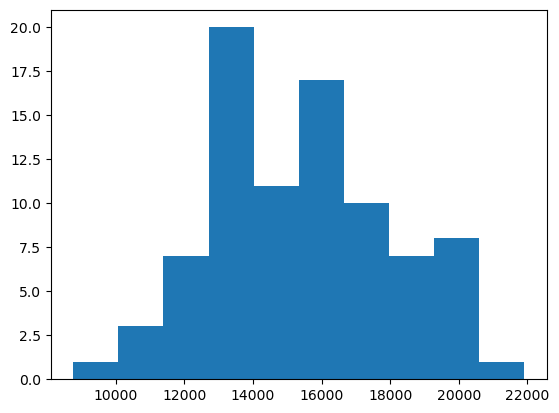

In [15]:
plt.hist(df_count.sum(axis=0));

In [18]:
df_count.sum(axis=1)

hgnc
ABL1      15502.0
ACVR1     14491.0
AKT1      14828.0
AKT2      11795.0
AKT3      19883.0
           ...   
STK40      6066.0
SYK       12132.0
TEK       15165.0
TGFBR1    18872.0
YES1      15502.0
Length: 84, dtype: float64

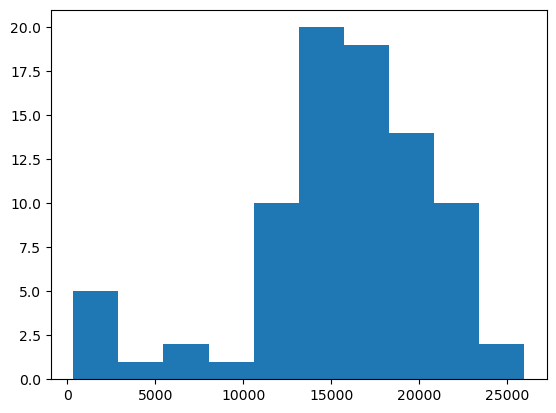

In [16]:
plt.hist(df_count.sum(axis=1));